# Data Wrangling with NRE Cleaned Cities

### What does this notebook do?
It is the analisys of the cleaned NRW vergabe data.


# Conclusions:
The COVID-19 related tenders colected through VERGABE.NRW API are the purchases made by public bodies that were not related to hospitals or health policies in general. This is duo to a federal policy that aimed to centrilize all purchases and avoid competition among cities and Ländern.

This dataset compreends the period between 17.12.2019 and 07.01.2022.

## 1. Main Problems

This data has two main problems:

1 - There is no stardazation of city names. Instead of using a unique city code, officials just write down the city name or the neighborhood (Stadtteil) the field ```buyer_name``` . Making more difficult to analyze the data grouped by city. It is worth mention that other information (latitude, longiude and zip code) have more than one value to each city. The ideal is a one single code number to each buyer entity.  

2 - There is data missing. This Dataset has 215 of the 396 cities, which means that 181 cities are missing. Besides, we are not sure that all purchases made by the cities included are in this dataset. Further investigation need to be done. From those cities, we only found COVID-19 related purchases for 35 of them (8% of NRW).

3 - Another huge problem is the lack of information about sellers and values. Only 4% of the procurements registred have the information about ```seller_name```, ```seller_town```, ```seller_country``` and ```result_value``` and the presence of this information is random. Without this important information, civil society cannot monitor basic things like comparing the value of the purchased item with purchases of the same iten in other towns, check if the company is allowed to governments or see if this company is somehow related to politicians. 

4 - There is also missing information in other fields: 7% of the field ```procedure_type```is blank. 

5 - It seems there is not much guidance for the public officials in charge of sending the information to the system. One example is the field ```result_description```, for each some entries has only a few words and for others have detailed description of products and its use. 

----

## 2. Purchases and types of procurement in the period

Due to the emergency rule setled in the beggining of the pandemic (SEE EXACT DATE), we expected that overall purchases would behave in a specific way, responding to the new needs (sanitizers, masks) and lockdown rules. However, this is not how the data behaved. 

**All procurements:** After the end of fiscal year, in December 2019, there was a new high demand of purchases in April 2020, the highest in the whole period. This can partially be related to the fact that many offices worked in home-office mode, so there were no need to buy many supplies during the following period. However, this does not look like a general trend that deals with the expection rule (See Gr.1) . 
Regarding the procedure type, the majority of procurements were the open competiton type (Öffentliche Ausschreibung) and all the othe procurement types, including the 5 Ex-Post types, had the same behavior among the type. 

**COVID-19 related procurements:** The purchases of COVID-19 related items followed the trend of the overall purchases, being higher in April 2020 and declining after that (see Gr. 7). However, 55% of the COVID-19 tenders were ex-post types, and only 30% were open competition (Öffentliche Ausschreibung). Besides, when we look at the distribution of types of procedures by time (Gr.9) we see that the ex-post purchases were higher between March and May 2021, close to the 2021's German Summer, when the conuntry was a bit opener. 

----

## 3. What was bought?

According to the ```result_title```, the two mainly itens bought were masks, schnelltests and lollitests for children (see wordcloud). Below there is also a list of public bodyes who purchased covid-19 related itens. I could not identify a interessant outcome of this.

----

# Code:

In [1]:
#Libraries
import pandas as pd
import numpy as np 
import plotly.express as px
import plotly.graph_objs as go
from IPython.display import display, HTML
import re

# PLT for the wordcloud:
import matplotlib.pyplot as plt

# Import package
from wordcloud import WordCloud, STOPWORDS 

In [2]:
#Glimpse function:
def glimpse(df, maxvals=10, maxlen=110):
    print('Shape: ', df.shape)
    
    def pad(y):
        max_len = max([len(x) for x in y])
        return [x.ljust(max_len) for x in y]
    
    # Column Name
    toprnt = pad(df.columns.tolist())
    
    # Column Type
    toprnt = pad([toprnt[i] + ' ' + str(df.iloc[:,i].dtype) for i in range(df.shape[1])])
    
    # Num NAs
    num_nas = [df.iloc[:,i].isnull().sum() for i in range(df.shape[1])]
    num_nas_ratio = [int(round(x*100/df.shape[0])) for x in num_nas]
    num_nas_str = [str(x) + ' (' + str(y) + '%)' for x,y in zip(num_nas, num_nas_ratio)]
    max_len = max([len(x) for x in num_nas_str])
    num_nas_str = [x.rjust(max_len) for x in num_nas_str]
    toprnt = [x + ' ' + y + ' NAs' for x,y in zip(toprnt, num_nas_str)]
    
    # Separator
    toprnt = [x + ' : ' for x in toprnt]
    
    # Values
    toprnt = [toprnt[i] + ', '.join([str(y) for y in df.iloc[:min([maxvals,df.shape[0]]), i]]) for i in range(df.shape[1])]
    
    # Trim to maxlen
    toprnt = [x[:min(maxlen, len(x))] for x in toprnt]
    
    for x in toprnt:
        print(x)
        

####sec function:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [3]:
#importing cleaned data:

df = pd.read_csv('3_data_nrw_clean_cities.csv', low_memory=False)

In [4]:
# what's the period englobed by this data?

print('The dataset has tenders from', min(df.created_at), 'until', max(df.created_at), 'which was the scrap date')

The dataset has tenders from 2019-12-17T14:29:56.168Z until 2022-01-07T02:11:51.498Z which was the scrap date


In [5]:
# df.result_procedure_type.unique()

### 0. Fixing the df

In [6]:
#creating a month-year column

df['month_year'] = pd.to_datetime(df['created_at']).dt.to_period('M')

#Sobrescrevendo NAs de uma coluna:
df.result_procedure_type = df.result_procedure_type.fillna('not_mentioned')

#Simplifying the procedure type:

simplified = {'Öffentliche Ausschreibung':'Öffentliche Ausschreibung',
              'Verhandlungsvergabe mit öffentlichem Teilnahmewettbewerb' : 'Verhandlungsvergabe mit öffentlichem Teilnahmewettbewerb',
              'Beschränkte Ausschreibung mit öffentlichem Teilnahmewettbewerb': 'Beschränkte Ausschreibung mit öffentlichem Teilnahmewettbewerb',
              'Beschränkte Ausschreibung mit Teilnahmewettbewerb' : 'Beschränkte Ausschreibung mit Teilnahmewettbewerb',
              'Teilnahmewettbewerb':'Teilnahmewettbewerb',
              'not_mentioned' : 'not_mentioned',
              'Ex post Veröffentlichung (§ 30 Abs. 1)':'ex_post',
              'Ex post Veröffentlichung':'ex_post',
              'Ex post Veröffentlichung (Binnenmarktrelevanz)':'ex_post', 
              'Ex post Veröffentlichung (§ 20 Abs.3)':'ex_post',
              'Ex post Veröffentlichung (§ 19 Abs.2)':'ex_post',
              'Ex ante Veröffentlichung':'ex_ante',
              'Ex ante Veröffentlichung (Binnenmarktrelevanz)':'ex_ante',
              'Ex ante Veröffentlichung (§ 19 Abs. 5)':'ex_ante'}

#df['simplified_procedure_type'] = df['result_procedure_type'].str.replace(simplified)

df['simplified_procedure_type'] = df['result_procedure_type']
df = df.replace({"simplified_procedure_type": simplified})

/Users/user/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [31]:
#Cheking last df version:

glimpse(df)

Shape:  (36561, 27)
_id                       object         0 (0%) NAs : CXPNY42D0ZS, CXPNY42DRDN, CXPNY42YT80, CXPNY42YWAX, CXPN
created_at                object         0 (0%) NAs : 2022-01-04T23:00:18.455Z, 2020-04-20T22:14:01.166Z, 2019
updated_at                object         0 (0%) NAs : 2022-01-06T23:00:14.633Z, 2020-05-19T00:33:44.632Z, 2020
result_id                 object         0 (0%) NAs : CXPNY42D0ZS, CXPNY42DRDN, CXPNY42YT80, CXPNY42YWAX, CXPN
result_title              object       531 (1%) NAs : Öffnen/Verschließen von Türen/Toren aller Art im Wege de
result_description        object         0 (0%) NAs : ['schüsseldienste kamen im kalenderjahr 2021 zu insgesam
result_procedure_type     object         0 (0%) NAs : Öffentliche Ausschreibung, Öffentliche Ausschreibung, Öf
result_order_type         object      2621 (7%) NAs : UVGO, UVGO, OTHER, nan, UVGO, UVGO, UVGO, UVGO, UVGO, UV
result_publication_date   object    25888 (71%) NAs : nan, nan, nan, nan, nan, nan, nan, nan

In [36]:
#x = df.query('result_procedure_type == "not_mentioned" ')
#x.shape

#int(2621/36561*100)

### 1.Distribution of tenders per month:

In [9]:
#Distribution of tenders per month
df1 = df.groupby('month_year').agg(value =('month_year', 'count')).reset_index()

fig = go.Figure(data=go.Scatter(x=df1['month_year'].astype(dtype=str), 
                                y=df1['value'],
                                marker_color='indianred', 
                                text="counts"))

fig.update_layout({"title": 'Gr.1 Distribuition of tenders per year-month',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total tenders"},
                   "showlegend": False})

#fig.write_image("tenders_per_month.png",format="png", width=1000, height=600, scale=3)
fig.show()

In the beggining of the system, we have a higher value os tenders added, but the amount of tenders go up and down during the period, beeing low at january 2022 partially due to lack of days (we got this data before 15.01.2022)

### 2. Proportion of types of tender:

In [10]:
#result_procedure_type

df2 = df 

df2 = df2.groupby('result_procedure_type').agg(value =('result_procedure_type', 'count')).reset_index()
df2 = df2.sort_values(by='value',ascending=False)

df2['percentage'] = (
    ((df2['value'] / df2['value'].sum()) * 100)
    .astype(int)
    .astype(str)) + '%'

# Ploting:
fig = go.Figure(data=go.Bar(x=df2['result_procedure_type'], 
                            y=df2['value'],
                            marker_color='indianred',
                            text=df2['percentage']))

fig.update_layout({"title": 'Gr.2 Distribution of Procedure Types',
                   "xaxis": {"title":"Type of procedure"},
                   "yaxis": {"title":"Total tenders"},
                   "showlegend": False})

fig.show()

In [11]:
#Result
print(int((2621/36561)*100), 
'% of the inputs did not mentioned the type of procedure (at the graph they are labeled as "not_mentioned".Circa',
int((16683/36531)*100), '% of the inputs were Public invitation to tender (Öffentliche Ausschreibung)')

7 % of the inputs did not mentioned the type of procedure (at the graph they are labeled as "not_mentioned".Circa 45 % of the inputs were Public invitation to tender (Öffentliche Ausschreibung)


In [12]:
#result_procedure_type

df2_1 = df

#Sobrescrevendo NAs de uma coluna:
df2_1.result_procedure_type = df2_1.result_procedure_type.fillna('not_mentioned')

df2_1 = df2_1.groupby(['result_procedure_type','month_year']).agg(value =('result_procedure_type', 'count')).reset_index()
df2_1['month_year'] = df2_1['month_year'].astype(dtype=str)
df2_1 = df2_1.sort_values(by='month_year',ascending=True)

fig = px.line(df2_1, x="month_year", y="value", color='result_procedure_type')
fig.update_layout({"title": 'Gr.3 Distribuition of procedure_types per year-month (all procurements)',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total tenders"},
                   "showlegend": True})

fig.show()

In [13]:
#result_procedure_type

df2_2 = df.groupby(['simplified_procedure_type','month_year']).agg(value =('simplified_procedure_type', 'count')).reset_index()
df2_2['month_year'] = df2_2['month_year'].astype(dtype=str)
df2_2 = df2_2.sort_values(by='month_year',ascending=True)

fig = px.line(df2_2, x="month_year", y="value", color='simplified_procedure_type')
fig.update_layout({"title": 'Gr.4 Distribuition of simplified procedure_types per year-month (all procurements)',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total tenders"},
                   "showlegend": True})

fig.show()

In [14]:
#All types of procedure available
sorted(df.result_procedure_type.unique())

['Beschränkte Ausschreibung mit Teilnahmewettbewerb',
 'Beschränkte Ausschreibung mit öffentlichem Teilnahmewettbewerb',
 'Ex ante Veröffentlichung',
 'Ex ante Veröffentlichung (Binnenmarktrelevanz)',
 'Ex ante Veröffentlichung (§ 19 Abs. 5)',
 'Ex post Veröffentlichung',
 'Ex post Veröffentlichung (Binnenmarktrelevanz)',
 'Ex post Veröffentlichung (§ 19 Abs.2)',
 'Ex post Veröffentlichung (§ 20 Abs.3)',
 'Ex post Veröffentlichung (§ 30 Abs. 1)',
 'Teilnahmewettbewerb',
 'Verhandlungsvergabe mit öffentlichem Teilnahmewettbewerb',
 'not_mentioned',
 'Öffentliche Ausschreibung']

In [15]:
#Distribuition of procedure_types per year-month (all procurements)

df2_3 = df

df2_3['type_procedure'] = np.where(df2_3['result_procedure_type'] == 'Öffentliche Ausschreibung', 'competitive', 'non-competitive')
df2_3['type_procedure'] = np.where(df2_3['result_procedure_type'] == 'not_mentioned', 'not_mentioned', df2_3['type_procedure'])

df2_3 = df.groupby(['type_procedure','month_year']).agg(value =('simplified_procedure_type', 'count')).reset_index()
df2_3['month_year'] = df2_3['month_year'].astype(dtype=str)
df2_3 = df2_3.sort_values(by='month_year',ascending=True)

fig = px.line(df2_3, x="month_year", y="value", color='type_procedure')
fig.update_layout({"title": 'Gr.5 Distribuition of procedure_types per year-month (all procurements)',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total tenders"},
                   "showlegend": True})

fig.show()

According to the OCDE report, we should see at the beggining of the pandemic an increase of the non-competitive procurements. But as we see, both types behave the same way.

### 3. Information about sellers:

In [16]:
#Looking at the ex post tenders to see if they have any information about sellers:

#filtering
df3 = df.query('simplified_procedure_type == "ex_post"')
glimpse(df3)

Shape:  (13330, 27)
_id                       object          0 (0%) NAs : CXPNY43D5NQ, CXPNY43D626, CXPNY43DD11, CXPNY43DD12, CXP
created_at                object          0 (0%) NAs : 2020-11-24T23:02:58.968Z, 2020-08-17T22:01:51.564Z, 202
updated_at                object          0 (0%) NAs : 2021-02-22T23:00:23.152Z, 2020-10-06T22:01:42.803Z, 202
result_id                 object          0 (0%) NAs : CXPNY43D5NQ, CXPNY43D626, CXPNY43DD11, CXPNY43DD12, CXP
result_title              object          0 (0%) NAs : Beschaffung von VMware vSphere 7 Lizenzen und Wartung, 
result_description        object          0 (0%) NAs : ['8 x VMware vSphere 7 Enterprise Plus 1 Processor', '8
result_procedure_type     object          0 (0%) NAs : Ex post Veröffentlichung (§ 30 Abs. 1), Ex post Veröffe
result_order_type         object          0 (0%) NAs : UVGO, UVGO, UVGO, UVGO, UVGO, UVGO, UVGO, UVGO, UVGO, U
result_publication_date   object    13330 (100%) NAs : nan, nan, nan, nan, nan, nan, nan, na

For all ex-post procedures, there is not a single record of ```result_value```, ```result_seller_name```, ```result_seller_town``` or ```result_seller_country```

In [17]:
#See when we have information about sellers and values:

df4 = df.query("result_value == result_value")
df4.result_procedure_type.unique()

array(['not_mentioned'], dtype=object)

In [18]:
# Distribution of tenders wirth result_value per year_month
df4 = df.groupby('month_year').agg(value =('month_year', 'count')).reset_index()

fig = go.Figure(data=go.Scatter(x=df4['month_year'].astype(dtype=str), 
                                y=df4['value'],
                                marker_color='indianred', 
                                text="counts"))

fig.update_layout({"title": 'Gr.6 Distribuition of tenders with result_value per year-month',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total tenders"},
                   "showlegend": False})

#fig.write_image("tenders_per_month.png",format="png", width=1000, height=600, scale=3)
fig.show()

In [19]:
#Result
print('We have 1436 inputs(', int((1436/36561)*100), '%) where the result_value is mentioned. For all of them, there is no register of procedure type')

We have 1436 inputs( 3 %) where the result_value is mentioned. For all of them, there is no register of procedure type


There is no way to know why these 4% of tenders have the data. 

Without data of sellers, there is no way we can do monitoring to know, for example, if a company is not allowed to sell to the government

In [20]:
# filtering for the COVID-19 related purchases

includeKeywords = ['coronavirus','covid-19','covid','covid19','sars','schweres akutes respiratorisches syndrom',
                   'FFP2', 'SARS-COV-2', 'sars-cov-2','sarscov2','Gesichtsschutz','Gesichtsschutzschild',
                   'Gesichtsvisier', 'Gesichtsmaske','Schutzanzug', 'Einweg-Schutzanzug', 'Atemschutzmaske', 
                   'Mundschutz', 'chirurgischer Mundschutz','chirurgischer-mundschutz', 'Schutzbrille', 
                   'persönliche Schutzbrille', 'Partikel-Respirator', 'EN 14683:2005', 'Handdesinfektionsmittel', 
                   'Beatmungsgerät', 'Respirator', '33157110-9' , 'Sauerstoffmaske', 'Herz-Lungen-Maschine', 
                   'Herz Lungen Maschine', 'HerzlungeMaschine']

includeKeywords = [key.lower() for key in includeKeywords]

df5 = df
df5['result_description'] = df5['result_description'].str.lower()

df5 = df5[df5['result_description'].str.contains('|'.join(includeKeywords))] 
df5.shape

(92, 27)

We have found only 92 inputs with the selected terms. Now we are going to look at them:

### 4. How many cities have covid-related vergabe?

In [21]:
# quantas cidades?

city_with_covid_vergabe = df5['cleaned_buyer_town'].unique()
all_cities = df['cleaned_buyer_town'].unique()

print("There are", len(city_with_covid_vergabe), "cities with COVID-related vergabe. Which is ", 
      int((len(city_with_covid_vergabe)/len(all_cities))*100), "% os all cities included in the database and",
     int((len(city_with_covid_vergabe)/396)*100), "% of all NRW cities")

There are 35 cities with COVID-related vergabe. Which is  16 % os all cities included in the database and 8 % of all NRW cities


### 5. Who is buying?

In [22]:
#who is buying?

sorted(df5['result_buyer_name'].unique())

['Ausländer- und Flüchtlingsamt',
 'Bau- und Liegenschaftsbetrieb NRW Dortmund',
 'Bezirksregierung Köln',
 'Bundesstadt Bonn - Referat Vergabedienste',
 'Deutsche Sporthochschule Köln',
 'Die Autobahn GmbH des Bundes, Niederlassung Westfalen AS Bochum',
 'EGK- Entsorgungsgesellschaft Krefeld Gmb',
 'Grün und Gruga',
 'HSPV NRW Zentralverwaltung',
 'JVA Castrop-Rauxel Zentralstelle für das Beschaffungswesen im Justizvollzug',
 'JVA Geldern',
 'Jobcenter Wuppertal AöR',
 'Kreis Mettmann - Der Landrat, Amt 10 -Zentrale Vergabestelle-',
 'Kreis Recklinghausen, Der Landrat',
 'Kreis Unna',
 'Kreis Unna - FB Schulen und Bildung',
 'Kreispolizeibehörde Hochsauerlandkreis',
 'Kreisstadt Bergheim Der Bürgermeister',
 'Kreisstadt Unna',
 'Landesamt für Zentrale Polizeiliche Dienste NRW',
 'Landesbetrieb Straßenbau NRW - Betriebssitz Gelsenkirchen',
 'Landeskriminalamt Nordrhein-Westfalen',
 'Ministerium für Kinder, Familie, Flüchtlinge und Integration des Landes NRW',
 'Ministerium für Schule u

### 6.What are they buying?

In [37]:
#What are they buying?
pd.set_option("display.max_rows", None)
df7 = df5[['cleaned_buyer_town', 'result_title']].sort_values(by=['cleaned_buyer_town'])

display(HTML(df7.to_html()))

### 7.What are they buying?

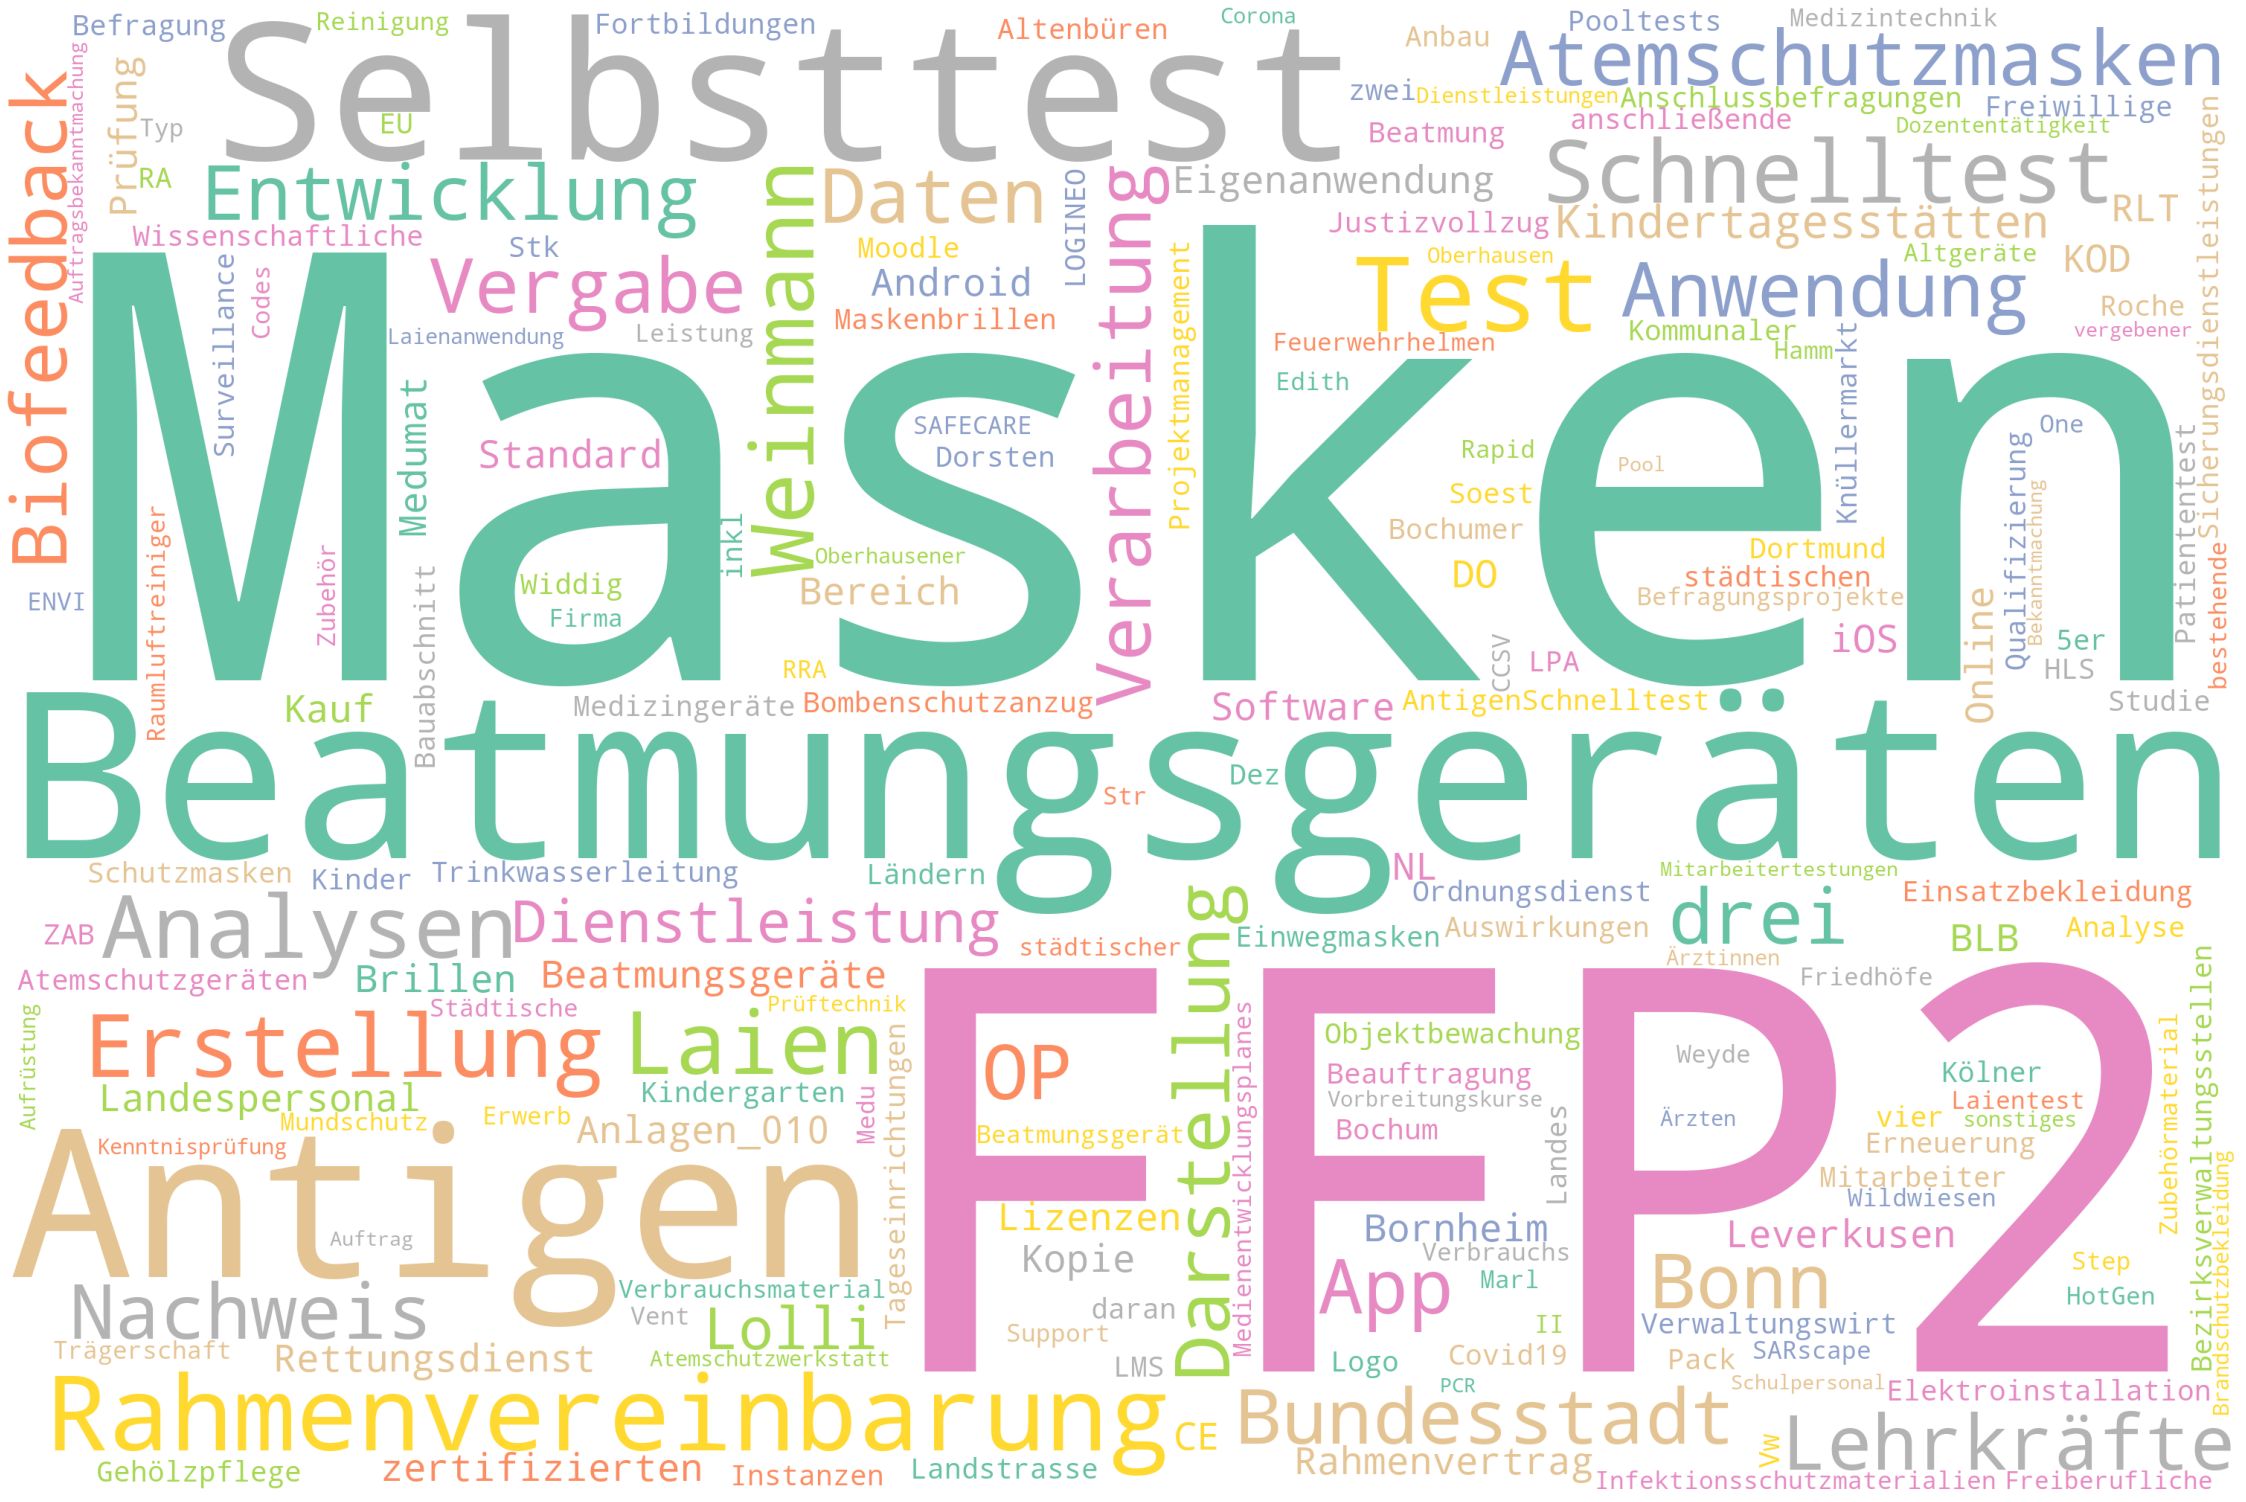

In [39]:
#Creating the Wordcloud
#importing german stopwords

from nltk.corpus import stopwords
stopset = stopwords.words('german')
new_words = ['innen', 'none', 'lieferung', 'en', 'nrw', 'aufgrund', 'stück', 'covid', 'sowie', 'ca',
             'kg', 'din', 'st', 'feuerwehr', 'stadt', 'ausschreibung', 'auftragnehmer', 'sollen', 
            'durchführung', 'schulen', 'erstelung', 'los', 'b', 'cov', 'sars', 'anlagen', 'anlage',
            'folgende', 'beschaffung', 'ertellung']

for i in new_words:
    stopset.append(i)
    
# You can first use .tolist to convert column to a list and then 
# use .join method to concat all separate words together.
text = ' '.join(df7['result_title'].tolist())

#cleaning
text = text.replace(r'\W', '')
text = re.sub("\[\\'","",text)
text = re.sub("\\'\]","",text)
text = re.sub("\\'", "", text)

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");


# Generate word cloud
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='white', 
                      colormap='Set2', collocations=False, stopwords = stopset).generate(text)
# Plot
plot_cloud(wordcloud)

### 8.When were they bought?

In [25]:
#When the COVID-19 related purchases were bought?
df8 = df5.groupby('month_year').agg(value =('month_year', 'count')).reset_index()

fig = go.Figure(data=go.Scatter(x=df1['month_year'].astype(dtype=str), 
                                y=df1['value'],
                                marker_color='blue', 
                                text="counts"))

fig.update_layout({"title": 'Gr.7 Distribuition of covid-19 related tenders per year-month',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total tenders"},
                   "showlegend": False})

#fig.write_image("tenders_per_month.png",format="png", width=1000, height=600, scale=3)
fig.show()

It doesn't say much.

### 9.What were the types of procedure used?

In [26]:
#result_procedure_type

df8 = df5.groupby('result_procedure_type').agg(value =('result_procedure_type', 'count')).reset_index()
df8 = df8.sort_values(by='value',ascending=False)

df8['percentage'] = (
    ((df8['value'] / df8['value'].sum()) * 100)
    .astype(int)
    .astype(str)) + '%'


# Ploting:
fig = go.Figure(data=go.Bar(x=df8['result_procedure_type'], 
                            y=df8['value'],
                            marker_color='blue',
                            text=df8['percentage']))

fig.update_layout({"title": 'Gr.8 Distribution of COVID-19 related Tenders Procedure Types',
                   "xaxis": {"title":"Type of procedure"},
                   "yaxis": {"title":"Total tenders"},
                   "showlegend": False})

fig.show()

55% of the tenders were ex-post type.

Let's see if the ex-post ones were mostly by the beggining of the pandemic

In [27]:
#result_procedure_type per year-month

df9 = df5.groupby(['simplified_procedure_type','month_year']).agg(value =('simplified_procedure_type', 'count')).reset_index()
df9['month_year'] = df9['month_year'].astype(dtype=str)
df9 = df9.sort_values(by='month_year',ascending=True)

fig = px.line(df9, x="month_year", y="value", color='simplified_procedure_type')
fig.update_layout({"title": 'Gr.9 Distribuition of simplified procedure_types per year-month (covid-19 related procurements',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total tenders"},
                   "showlegend": True})

fig.show()

We see that in May 2021 it was the highest rate of purchases made by ex-post procedures. 
The purchases made in this dataset are not for hospitals, but for government bodies. Particularly, I don't see why july 2021 would be the moment with the most ex-post procurements.

In [40]:
%%capture
!jupyter nbconvert --to html --no-input --no-prompt "4.Data_Wrangling_with_NRW_cleaned_cities.ipynb"